# 1. Install Dependencies and Setup

In [135]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\nuwan\AppData\Local\Temp\pip-install-uc2v4y12\tensorflow-gpu_e308ce74630d42ad88a311dc88a806c0\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not buil

In [136]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.0.0
altair                       5.1.1
anyio                        4.0.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.4.0
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
blinker                      1.6.2
cachetools                   5.3.1
certifi                      2023.7.22
cffi                         1.15.1
charset-normalizer           3.2.0
click                        8.1.7
colorama                     0.4.6
comm                         0.1.4
comtypes                     1.2.0
contourpy                    1.1.1
cycler                       0.11.0
debugpy                      1.8.0



[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [137]:
import tensorflow as tf
import os

In [138]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [139]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [140]:
import cv2
import imghdr

In [141]:
data_dir = 'data' 

In [142]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [143]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [144]:
import numpy as np
from matplotlib import pyplot as plt

In [145]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [146]:
data_iterator = data.as_numpy_iterator()

In [147]:
batch = data_iterator.next()

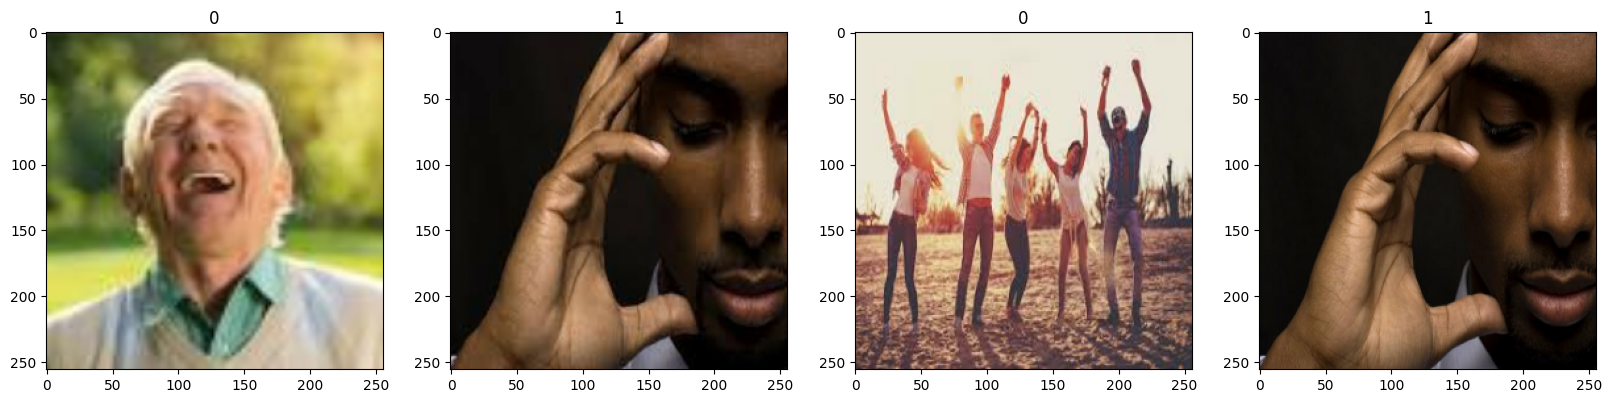

In [148]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [149]:
data = data.map(lambda x,y: (x/255, y))

In [150]:
data.as_numpy_iterator().next()

(array([[[[0.98566175, 0.9425245 , 0.93468136],
          [0.9981618 , 0.9503676 , 0.94644606],
          [0.99669117, 0.9474265 , 0.9474265 ],
          ...,
          [0.99558824, 0.95490193, 0.95098037],
          [0.99742645, 0.9460784 , 0.94215685],
          [0.9935049 , 0.9386029 , 0.93468136]],
 
         [[0.9625    , 0.9193627 , 0.9115196 ],
          [0.96862745, 0.9137255 , 0.9098039 ],
          [0.9759804 , 0.90539217, 0.90539217],
          ...,
          [0.96813726, 0.9132353 , 0.90931374],
          [0.9714461 , 0.91654414, 0.9126226 ],
          [0.96642154, 0.9115196 , 0.907598  ]],
 
         [[0.97205883, 0.9171569 , 0.9132353 ],
          [0.9660539 , 0.9033088 , 0.9033088 ],
          [0.98406863, 0.90563726, 0.90955883],
          ...,
          [0.9762255 , 0.9134804 , 0.9134804 ],
          [0.9759804 , 0.9132353 , 0.9132353 ],
          [0.96813726, 0.90539217, 0.90539217]],
 
         ...,
 
         [[0.9667892 , 0.9118872 , 0.9001225 ],
          [0.95894

# 5. Split Data

In [151]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [152]:
train_size

7

In [153]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [154]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [155]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [156]:
model = Sequential()

In [157]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [158]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [159]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 16)       

# 7. Train

In [160]:
logdir='logs'

In [161]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [162]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


7/7 [==============================] - 10s 1s/step - loss: 1.3216 - accuracy: 0.5625 - val_loss: 0.7405 - val_accuracy: 0.4688
Epoch 2/20
7/7 [==============================] - 9s 1s/step - loss: 0.7125 - accuracy: 0.4866 - val_loss: 0.6863 - val_accuracy: 0.5312
Epoch 3/20
7/7 [==============================] - 9s 1s/step - loss: 0.6696 - accuracy: 0.5982 - val_loss: 0.5990 - val_accuracy: 0.7656
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 0.5638 - accuracy: 0.7634 - val_loss: 0.5007 - val_accuracy: 0.7656
Epoch 5/20
7/7 [==============================] - 9s 1s/step - loss: 0.4595 - accuracy: 0.7946 - val_loss: 0.3668 - val_accuracy: 0.8906
Epoch 6/20
7/7 [==============================] - 9s 1s/step - loss: 0.3477 - accuracy: 0.8705 - val_loss: 0.3035 - val_accuracy: 0.9062
Epoch 7/20
7/7 [==============================] - 9s 1s/step - loss: 0.3466 - accuracy: 0.8393 - val_loss: 0.3252 - val_accuracy: 0.8750
Epoch 8/20
7/7 [==============================] - 9

# 8. Plot Performance

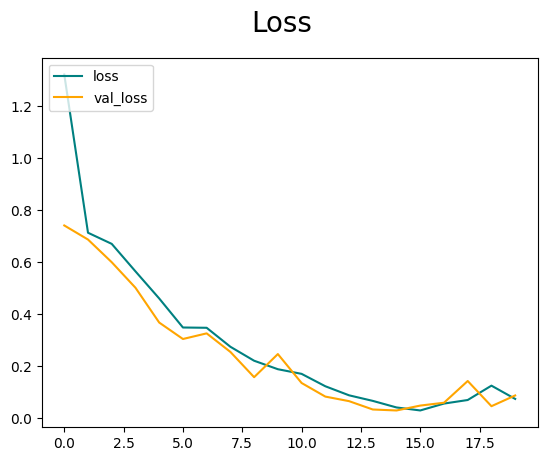

In [163]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

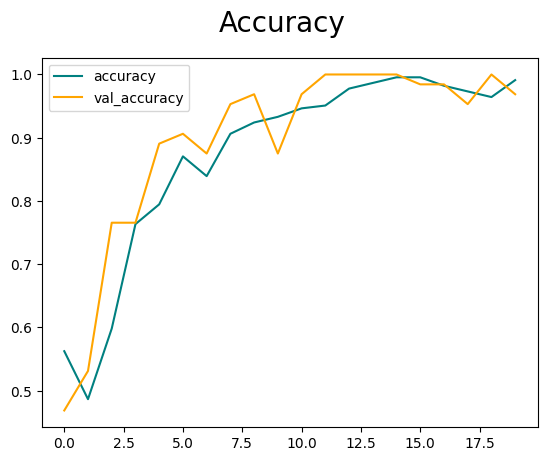

In [164]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [165]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [166]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [167]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 178ms/step


In [168]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9411765, shape=(), dtype=float32)


# 10. Test

In [169]:
import cv2

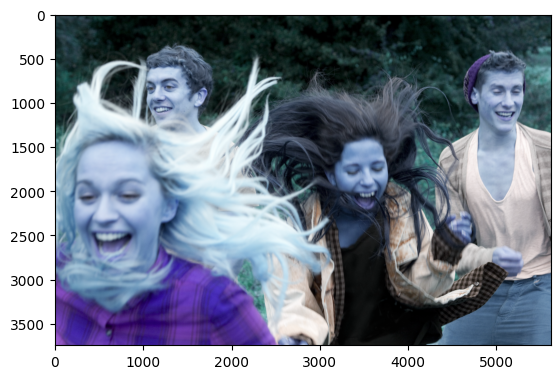

In [170]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

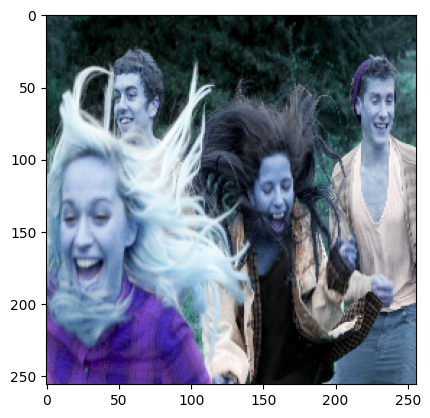

In [171]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [172]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 35ms/step


In [173]:
yhat

array([[0.28634918]], dtype=float32)

In [174]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [175]:
from tensorflow.keras.models import load_model

In [176]:
model.save(os.path.join('models','imageclassifier.h5'))

In [177]:
new_model = load_model('imageclassifier.h5')

In [178]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 84ms/step


array([[0.1464898]], dtype=float32)